# PA Quantum Neuron

Build a classical neuron with a quantum circuit

In [1]:
from colorama import Fore, Back, Style 

import numpy as numpy
from pennylane import numpy as np
import pennylane as qml
from pennylane.optimize import NesterovMomentumOptimizer
from pennylane.math import requires_grad

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

from math import pi


# Quantum

In [2]:
max_iterations = 50
loop_count = 13

In [3]:

dev_1 = qml.device('default.qubit', wires=1)
dev_2 = qml.device('default.qubit', wires=1)
dev_3 = qml.device('default.qubit', wires=1)

## Classifier 1
weights_count = 3
init_weights_1 = (0.01 * np.random.randn(weights_count), 0.0)

print(init_weights_1)

@qml.qnode(dev_1)
def circuit_1(weights, data):
    qml.RY(data[0], wires=0) # input feature 1
    qml.RY(data[1], wires=0) # input feature 2
    qml.Rot(weights[0], weights[1], weights[2], wires=0) # weight 1
    
    return qml.expval(qml.PauliZ(0))

def vc_classifier_1(var, data):
    weights = var[0]
    bias = var[1]
    return circuit_1(weights, data) + bias


## Classifier 2
weights_count = 6
init_weights_2 = (0.01 * np.random.randn(weights_count), 0.0)

@qml.qnode(dev_2)
def circuit_2(weights, data):
    qml.RY(data[0], wires=0) # input feature 1
    qml.Rot(weights[0], weights[1], weights[2], wires=0) # weight 1
    
    qml.RY(data[1], wires=0) # input feature 2
    qml.Rot(weights[3], weights[4], weights[5], wires=0) # weight 2

    return qml.expval(qml.PauliZ(0))

def vc_classifier_2(var, data):
    weights = var[0]
    bias = var[1]
    return circuit_2(weights, data) + bias
  

## Classifier 3
weights_count = 6
init_weights_3 = (0.01 * np.random.randn(weights_count), 0.0)

@qml.qnode(dev_3)
def circuit_3(weights, data):
    qml.RY(data[0], wires=0) # input feature 1
    qml.Rot(weights[0], weights[1], weights[2], wires=0) # weight 1
    
    qml.RX(data[1], wires=0) # input feature 2
    qml.Rot(weights[3], weights[4], weights[5], wires=0) # weight 2
    
    return qml.expval(qml.PauliZ(0))

def vc_classifier_3(var, data):
    weights = var[0]
    bias = var[1]
    return circuit_3(weights, data) + bias


## generic
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2
    loss = loss / len(labels)
    return loss

def cost(vc_classifier, weights, datas, labels):
    predictions = [vc_classifier(weights, f) for f in datas]
    return square_loss(labels, predictions)

def accuracy(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)
    return loss
  
def plot_costs(costs, num_layers):
  # plot costs
   fig, (ax1) = plt.subplots(1)
   fig.suptitle('Costs')
   ax1.plot(range(len(costs)), costs, label='Layers: {}'.format(num_layers))
   ax1.set_xlabel('iteration number')
   ax1.set_ylabel('cost objective function')
   ax1.legend(loc="upper right")
   plt.show()

# init weights
# var_init = (0.01 * np.random.randn(1, 2, 3), 0.0)


(tensor([-0.00806481,  0.01371886,  0.0072319 ], requires_grad=True), 0.0)


In [4]:
def vc_quantum(vc_classifier, init_weights, x_train, x_test, X, y_train, y_test, Y):
  opt = NesterovMomentumOptimizer(0.01)
  batch_size = 5
  var = init_weights
  iterations = max_iterations
  costs = np.zeros(iterations) 

  for it in range(iterations):

      # Update the weights by one optimizer step
      batch_index = np.random.randint(0, len(x_train), (batch_size,))
      feats_train_batch = x_train[batch_index]
      Y_train_batch = y_train[batch_index]
      var, stepCost = opt.step_and_cost(lambda v: cost(vc_classifier, v, feats_train_batch, Y_train_batch), var)
      # print("trained weights and bias (var):", var)

      # Compute predictions on train and validation set
      predictions_train = [np.sign(vc_classifier(var, f)) for f in x_train]
      predictions_val = [np.sign(vc_classifier(var, f)) for f in x_test]
      predictions_all = [np.sign(vc_classifier(var, f)) for f in X]

      # Compute accuracy on train and validation set
      acc_train = accuracy(y_train, predictions_train)
      acc_val = accuracy(y_test, predictions_val)
      acc_all = accuracy(Y, predictions_all)

      # gather informations for plotting
      costs[it] = cost(vc_classifier, var, X, Y)

      print(
          "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc val: {:0.7f} | Acc all: {:0.7f} "
          "".format(it + 1, costs[it], acc_train, acc_val, acc_all)
      )
  
  return [var, acc_val]

# plot costs
# plot_costs(costs, 0)

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6780157 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.5926672 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.4711701 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     4 | Cost: 1.3577887 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5500000 
Iter:     5 | Cost: 1.2410293 | Acc train: 0.5733333 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     6 | Cost: 1.1204454 | Acc train: 0.5866667 | Acc val: 0.6400000 | Acc all: 0.5800000 
Iter:     7 | Cost: 1.0153022 | Acc train: 0.6133333 | Acc val: 0.7200000 | Acc all: 0.6300000 
Iter:     8 | Cost: 0.9096419 | Acc train: 0.6400000 | Acc val: 0.7200000 | Acc all: 0.6500000 
Iter:     9 | Cost: 0.8141329 | Acc train: 0.6400000 | Acc val: 0.7600000 | Acc all: 0.6600000 
Iter:    10 | Cost: 0.7349148 | Acc train: 0.6666667 | Acc val: 0.8800000 | Acc all: 0.6800000 
Iter:    11 | Cost: 0.6861390 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.4130539 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.3706151 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.3123190 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.2398056 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     5 | Cost: 1.1798126 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5500000 
Iter:     6 | Cost: 1.1058012 | Acc train: 0.5866667 | Acc val: 0.6000000 | Acc all: 0.5800000 
Iter:     7 | Cost: 1.0402510 | Acc train: 0.5866667 | Acc val: 0.6400000 | Acc all: 0.5800000 
Iter:     8 | Cost: 0.9781530 | Acc train: 0.6133333 | Acc val: 0.6800000 | Acc all: 0.6000000 
Iter:     9 | Cost: 0.9318305 | Acc train: 0.6266667 | Acc val: 0.7200000 | Acc all: 0.6300000 
Iter:    10 | Cost: 0.8895371 | Acc train: 0.6666667 | Acc val: 0.7600000 | Acc all: 0.6700000 
Iter:    11 | Cost: 0.8606968 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6875994 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.6197730 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5180755 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.4107431 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.3170607 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.4900000 
Iter:     6 | Cost: 1.2221080 | Acc train: 0.5200000 | Acc val: 0.6000000 | Acc all: 0.5200000 
Iter:     7 | Cost: 1.1485577 | Acc train: 0.5066667 | Acc val: 0.6000000 | Acc all: 0.5200000 
Iter:     8 | Cost: 1.0981313 | Acc train: 0.5200000 | Acc val: 0.6000000 | Acc all: 0.5200000 
Iter:     9 | Cost: 1.0533328 | Acc train: 0.5733333 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:    10 | Cost: 1.0258501 | Acc train: 0.5466667 | Acc val: 0.5200000 | Acc all: 0.5400000 
Iter:    11 | Cost: 1.0094827 | Acc trai

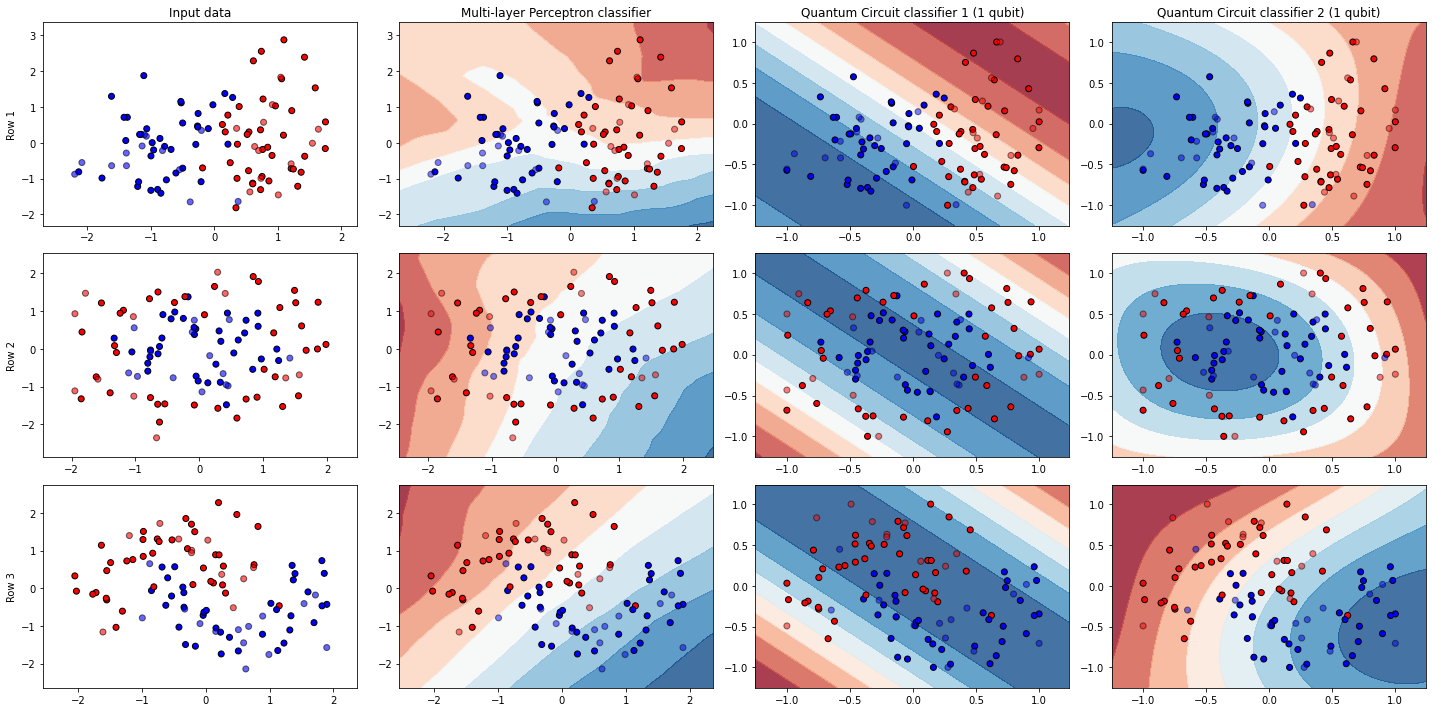

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6913172 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.6232576 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.5294695 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.4145624 | Acc train: 0.5333333 | Acc val: 0.5200000 | Acc all: 0.5200000 
Iter:     5 | Cost: 1.3068727 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5500000 
Iter:     6 | Cost: 1.2066800 | Acc train: 0.5466667 | Acc val: 0.6000000 | Acc all: 0.5500000 
Iter:     7 | Cost: 1.1261442 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5500000 
Iter:     8 | Cost: 1.0390426 | Acc train: 0.5733333 | Acc val: 0.6800000 | Acc all: 0.5700000 
Iter:     9 | Cost: 0.9533974 | Acc train: 0.6133333 | Acc val: 0.6800000 | Acc all: 0.6100000 
Iter:    10 | Cost: 0.8901577 | Acc train: 0.6133333 | Acc val: 0.6800000 | Acc all: 0.6200000 
Iter:    11 | Cost: 0.8587777 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.3889995 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.3347528 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.2678722 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     4 | Cost: 1.1938366 | Acc train: 0.5200000 | Acc val: 0.6000000 | Acc all: 0.5400000 
Iter:     5 | Cost: 1.1133313 | Acc train: 0.5866667 | Acc val: 0.6000000 | Acc all: 0.5800000 
Iter:     6 | Cost: 1.0426140 | Acc train: 0.5866667 | Acc val: 0.6400000 | Acc all: 0.5800000 
Iter:     7 | Cost: 0.9784695 | Acc train: 0.6133333 | Acc val: 0.6800000 | Acc all: 0.6000000 
Iter:     8 | Cost: 0.9225234 | Acc train: 0.6533333 | Acc val: 0.7200000 | Acc all: 0.6400000 
Iter:     9 | Cost: 0.8813145 | Acc train: 0.6800000 | Acc val: 0.7600000 | Acc all: 0.6700000 
Iter:    10 | Cost: 0.8533369 | Acc train: 0.6933333 | Acc val: 0.8000000 | Acc all: 0.7000000 
Iter:    11 | Cost: 0.8375462 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.7006020 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.6597860 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5937311 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.5080844 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.4247515 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     6 | Cost: 1.3367135 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.4900000 
Iter:     7 | Cost: 1.2672403 | Acc train: 0.4666667 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     8 | Cost: 1.2010460 | Acc train: 0.5200000 | Acc val: 0.6000000 | Acc all: 0.5200000 
Iter:     9 | Cost: 1.1346908 | Acc train: 0.5066667 | Acc val: 0.6000000 | Acc all: 0.5200000 
Iter:    10 | Cost: 1.0744895 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:    11 | Cost: 1.0344706 | Acc trai

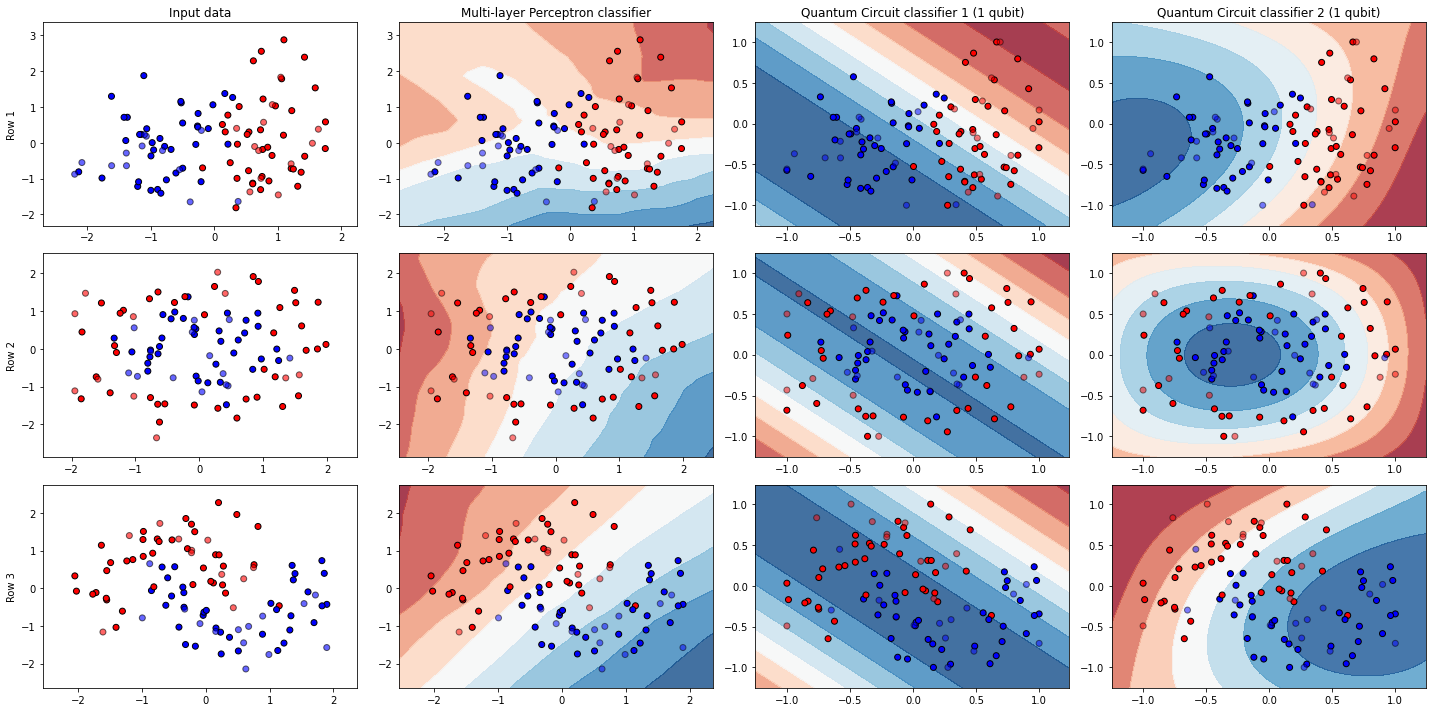

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.7128382 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.6602467 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.6102175 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.5238588 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     5 | Cost: 1.4232743 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5400000 
Iter:     6 | Cost: 1.2988107 | Acc train: 0.5733333 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     7 | Cost: 1.1669371 | Acc train: 0.5866667 | Acc val: 0.6400000 | Acc all: 0.5800000 
Iter:     8 | Cost: 1.0489724 | Acc train: 0.6000000 | Acc val: 0.6800000 | Acc all: 0.6000000 
Iter:     9 | Cost: 0.9190055 | Acc train: 0.6400000 | Acc val: 0.7200000 | Acc all: 0.6500000 
Iter:    10 | Cost: 0.8110746 | Acc train: 0.6400000 | Acc val: 0.7600000 | Acc all: 0.6600000 
Iter:    11 | Cost: 0.7292681 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.3959780 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.3683052 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.3332625 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.2643171 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     5 | Cost: 1.1939670 | Acc train: 0.5600000 | Acc val: 0.5600000 | Acc all: 0.5400000 
Iter:     6 | Cost: 1.1282500 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5700000 
Iter:     7 | Cost: 1.0654396 | Acc train: 0.5733333 | Acc val: 0.6400000 | Acc all: 0.5800000 
Iter:     8 | Cost: 0.9995864 | Acc train: 0.6133333 | Acc val: 0.6800000 | Acc all: 0.6200000 
Iter:     9 | Cost: 0.9482113 | Acc train: 0.6266667 | Acc val: 0.6800000 | Acc all: 0.6200000 
Iter:    10 | Cost: 0.9194998 | Acc train: 0.6400000 | Acc val: 0.6400000 | Acc all: 0.6500000 
Iter:    11 | Cost: 0.9016213 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6838146 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.6240506 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5530847 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.4619729 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.3743623 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     6 | Cost: 1.3078047 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     7 | Cost: 1.2557950 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     8 | Cost: 1.1927143 | Acc train: 0.5066667 | Acc val: 0.6000000 | Acc all: 0.5300000 
Iter:     9 | Cost: 1.1215955 | Acc train: 0.5200000 | Acc val: 0.6000000 | Acc all: 0.5300000 
Iter:    10 | Cost: 1.0604831 | Acc train: 0.5333333 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:    11 | Cost: 1.0232652 | Acc trai

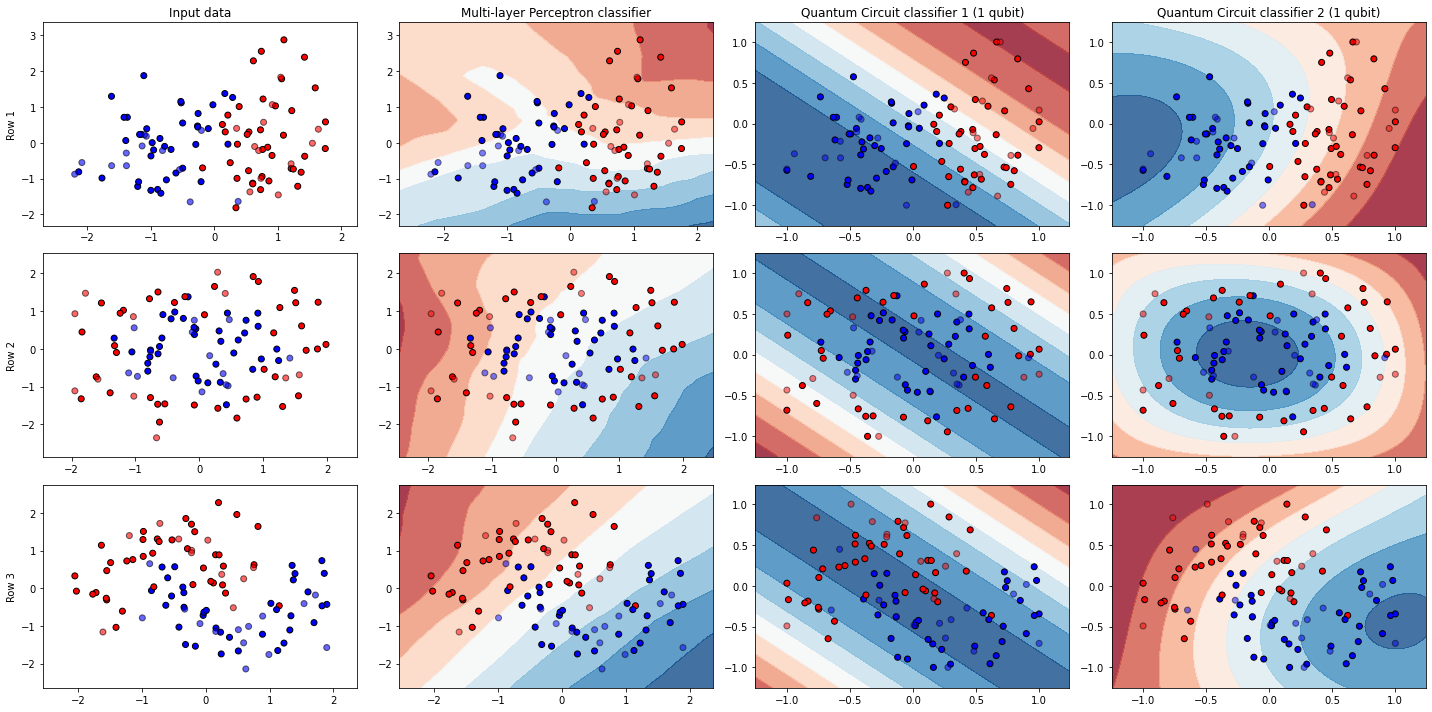

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.7267326 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.6935135 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.6615449 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.5894072 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.5185362 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     6 | Cost: 1.4209996 | Acc train: 0.5200000 | Acc val: 0.5200000 | Acc all: 0.5200000 
Iter:     7 | Cost: 1.3202052 | Acc train: 0.5200000 | Acc val: 0.5200000 | Acc all: 0.5400000 
Iter:     8 | Cost: 1.2227112 | Acc train: 0.5466667 | Acc val: 0.6000000 | Acc all: 0.5500000 
Iter:     9 | Cost: 1.1335112 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5500000 
Iter:    10 | Cost: 1.0494976 | Acc train: 0.5733333 | Acc val: 0.6400000 | Acc all: 0.5600000 
Iter:    11 | Cost: 0.9700284 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.4063002 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.3816083 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.3471788 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.2944277 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     5 | Cost: 1.2403119 | Acc train: 0.5600000 | Acc val: 0.5600000 | Acc all: 0.5500000 
Iter:     6 | Cost: 1.2010444 | Acc train: 0.5600000 | Acc val: 0.5600000 | Acc all: 0.5500000 
Iter:     7 | Cost: 1.1493490 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5500000 
Iter:     8 | Cost: 1.0984598 | Acc train: 0.5733333 | Acc val: 0.6000000 | Acc all: 0.5700000 
Iter:     9 | Cost: 1.0429783 | Acc train: 0.5866667 | Acc val: 0.6400000 | Acc all: 0.6000000 
Iter:    10 | Cost: 0.9870207 | Acc train: 0.6000000 | Acc val: 0.6800000 | Acc all: 0.6200000 
Iter:    11 | Cost: 0.9455863 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6757418 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.5881256 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.4884247 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.3747621 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.4900000 
Iter:     5 | Cost: 1.2678949 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5200000 
Iter:     6 | Cost: 1.1769682 | Acc train: 0.5066667 | Acc val: 0.6000000 | Acc all: 0.5200000 
Iter:     7 | Cost: 1.0963674 | Acc train: 0.4933333 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     8 | Cost: 1.0451865 | Acc train: 0.4933333 | Acc val: 0.5600000 | Acc all: 0.4700000 
Iter:     9 | Cost: 1.0137244 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:    10 | Cost: 0.9948809 | Acc train: 0.5466667 | Acc val: 0.6800000 | Acc all: 0.5400000 
Iter:    11 | Cost: 0.9908697 | Acc trai

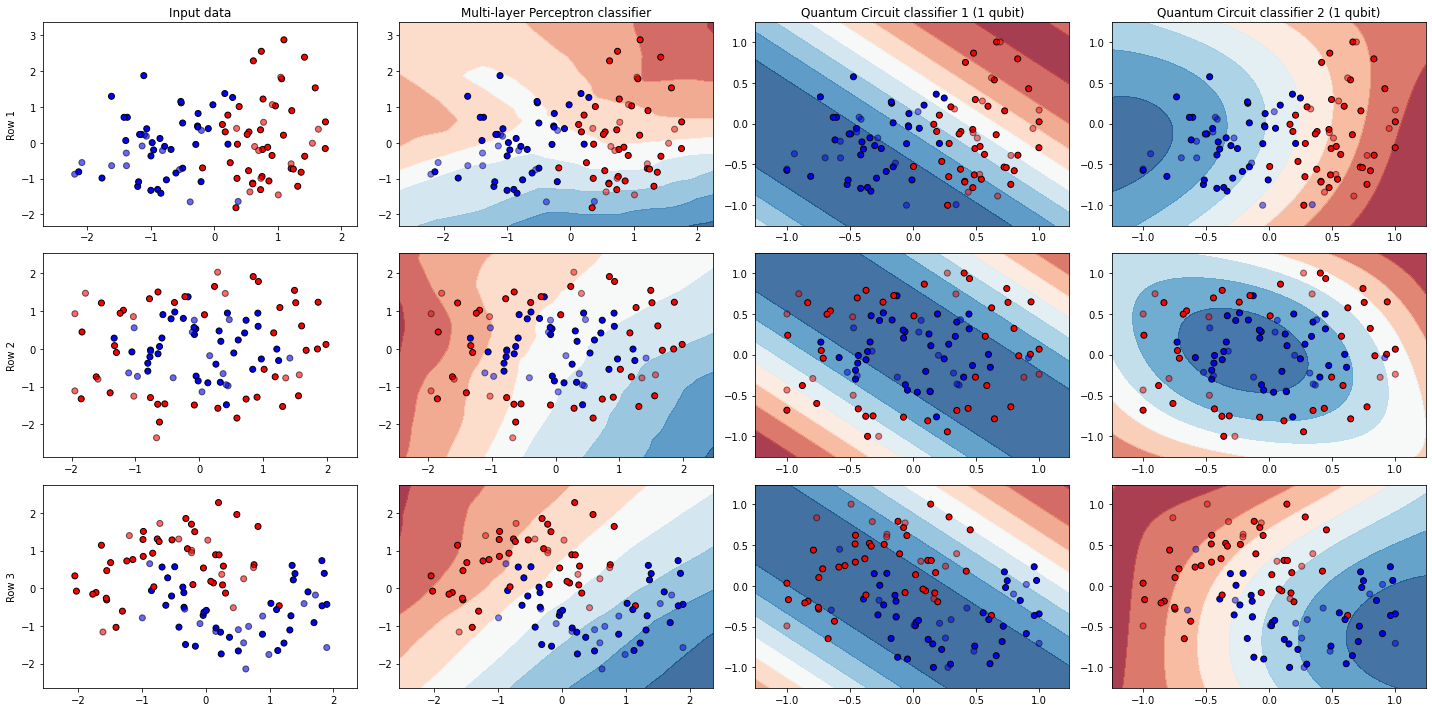

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6883968 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.6070600 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5122107 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.4192713 | Acc train: 0.5333333 | Acc val: 0.5200000 | Acc all: 0.5200000 
Iter:     5 | Cost: 1.3179221 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5500000 
Iter:     6 | Cost: 1.2165413 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5500000 
Iter:     7 | Cost: 1.1320070 | Acc train: 0.5733333 | Acc val: 0.6000000 | Acc all: 0.5600000 
Iter:     8 | Cost: 1.0475102 | Acc train: 0.5866667 | Acc val: 0.6400000 | Acc all: 0.5800000 
Iter:     9 | Cost: 0.9731498 | Acc train: 0.6133333 | Acc val: 0.6800000 | Acc all: 0.6100000 
Iter:    10 | Cost: 0.9120798 | Acc train: 0.6266667 | Acc val: 0.6800000 | Acc all: 0.6300000 
Iter:    11 | Cost: 0.8570328 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.3912527 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.3367264 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.2535062 | Acc train: 0.5600000 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     4 | Cost: 1.1560671 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5500000 
Iter:     5 | Cost: 1.0733304 | Acc train: 0.5733333 | Acc val: 0.6400000 | Acc all: 0.5800000 
Iter:     6 | Cost: 1.0057037 | Acc train: 0.6000000 | Acc val: 0.6800000 | Acc all: 0.6100000 
Iter:     7 | Cost: 0.9525231 | Acc train: 0.6266667 | Acc val: 0.6800000 | Acc all: 0.6200000 
Iter:     8 | Cost: 0.9110558 | Acc train: 0.6533333 | Acc val: 0.7200000 | Acc all: 0.6500000 
Iter:     9 | Cost: 0.8801638 | Acc train: 0.6666667 | Acc val: 0.6800000 | Acc all: 0.6700000 
Iter:    10 | Cost: 0.8580697 | Acc train: 0.6933333 | Acc val: 0.7200000 | Acc all: 0.6800000 
Iter:    11 | Cost: 0.8444537 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.7055366 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.6582186 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5891212 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.5065021 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     5 | Cost: 1.4063121 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     6 | Cost: 1.3170665 | Acc train: 0.5066667 | Acc val: 0.6000000 | Acc all: 0.5200000 
Iter:     7 | Cost: 1.2349617 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5300000 
Iter:     8 | Cost: 1.1771098 | Acc train: 0.5600000 | Acc val: 0.5600000 | Acc all: 0.5900000 
Iter:     9 | Cost: 1.1280155 | Acc train: 0.5333333 | Acc val: 0.5600000 | Acc all: 0.5600000 
Iter:    10 | Cost: 1.0971704 | Acc train: 0.5200000 | Acc val: 0.5200000 | Acc all: 0.5300000 
Iter:    11 | Cost: 1.0760585 | Acc trai

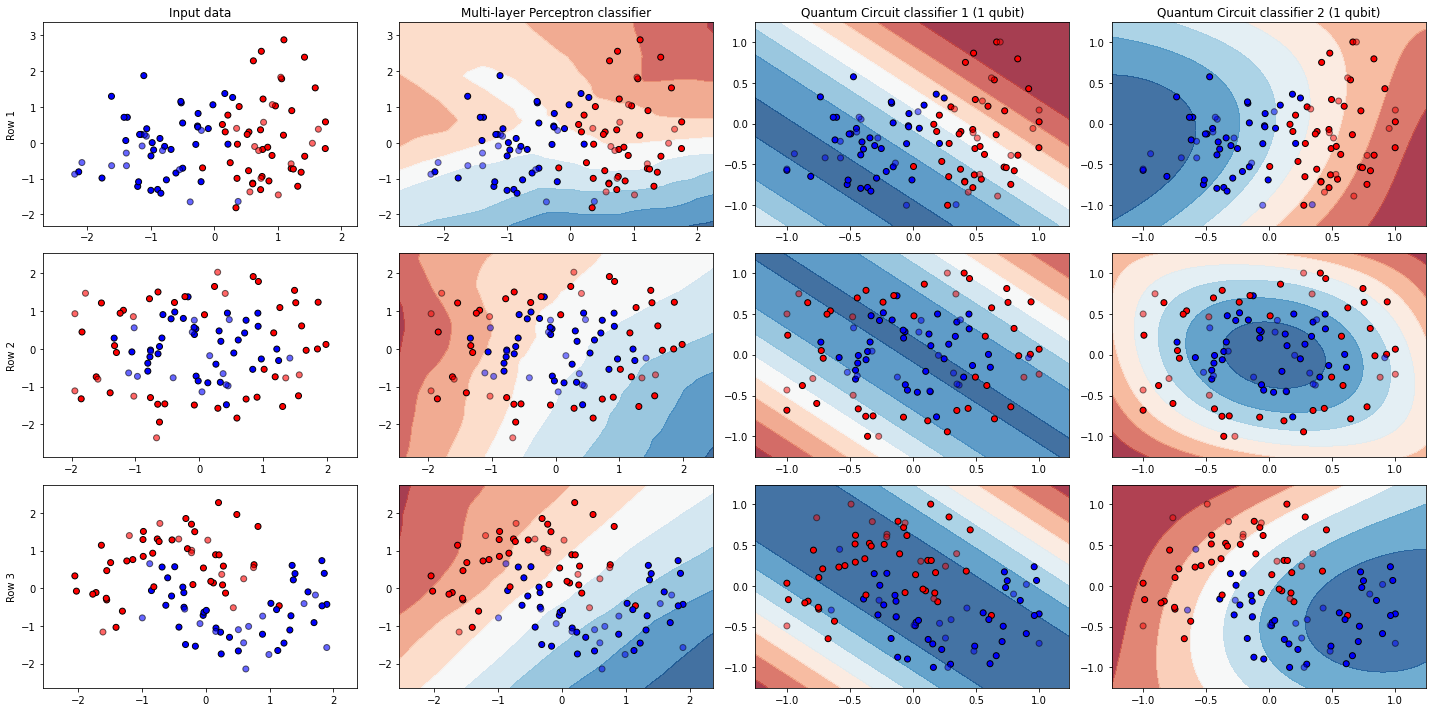

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6742895 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.5840536 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.4827879 | Acc train: 0.5333333 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     4 | Cost: 1.3752467 | Acc train: 0.5333333 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     5 | Cost: 1.2590305 | Acc train: 0.5600000 | Acc val: 0.6400000 | Acc all: 0.5600000 
Iter:     6 | Cost: 1.1470478 | Acc train: 0.5733333 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     7 | Cost: 1.0338326 | Acc train: 0.6000000 | Acc val: 0.7200000 | Acc all: 0.5900000 
Iter:     8 | Cost: 0.9304736 | Acc train: 0.6400000 | Acc val: 0.7200000 | Acc all: 0.6400000 
Iter:     9 | Cost: 0.8467203 | Acc train: 0.6266667 | Acc val: 0.7200000 | Acc all: 0.6600000 
Iter:    10 | Cost: 0.7714874 | Acc train: 0.6666667 | Acc val: 0.8400000 | Acc all: 0.6800000 
Iter:    11 | Cost: 0.7240717 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.3940075 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.3545502 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.3026822 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     4 | Cost: 1.2473205 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     5 | Cost: 1.1696082 | Acc train: 0.5466667 | Acc val: 0.6000000 | Acc all: 0.5500000 
Iter:     6 | Cost: 1.1011490 | Acc train: 0.5866667 | Acc val: 0.6000000 | Acc all: 0.5800000 
Iter:     7 | Cost: 1.0427242 | Acc train: 0.5866667 | Acc val: 0.6400000 | Acc all: 0.5800000 
Iter:     8 | Cost: 0.9883428 | Acc train: 0.6133333 | Acc val: 0.6800000 | Acc all: 0.5900000 
Iter:     9 | Cost: 0.9358056 | Acc train: 0.6266667 | Acc val: 0.6800000 | Acc all: 0.6300000 
Iter:    10 | Cost: 0.8952978 | Acc train: 0.6666667 | Acc val: 0.7600000 | Acc all: 0.6600000 
Iter:    11 | Cost: 0.8616485 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6581273 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.5851923 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.4913560 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.3882914 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.2891063 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.4900000 
Iter:     6 | Cost: 1.2095028 | Acc train: 0.5200000 | Acc val: 0.6000000 | Acc all: 0.5200000 
Iter:     7 | Cost: 1.1276372 | Acc train: 0.5066667 | Acc val: 0.6000000 | Acc all: 0.5200000 
Iter:     8 | Cost: 1.0699565 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     9 | Cost: 1.0275728 | Acc train: 0.5466667 | Acc val: 0.5200000 | Acc all: 0.5100000 
Iter:    10 | Cost: 1.0068225 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:    11 | Cost: 0.9969124 | Acc trai

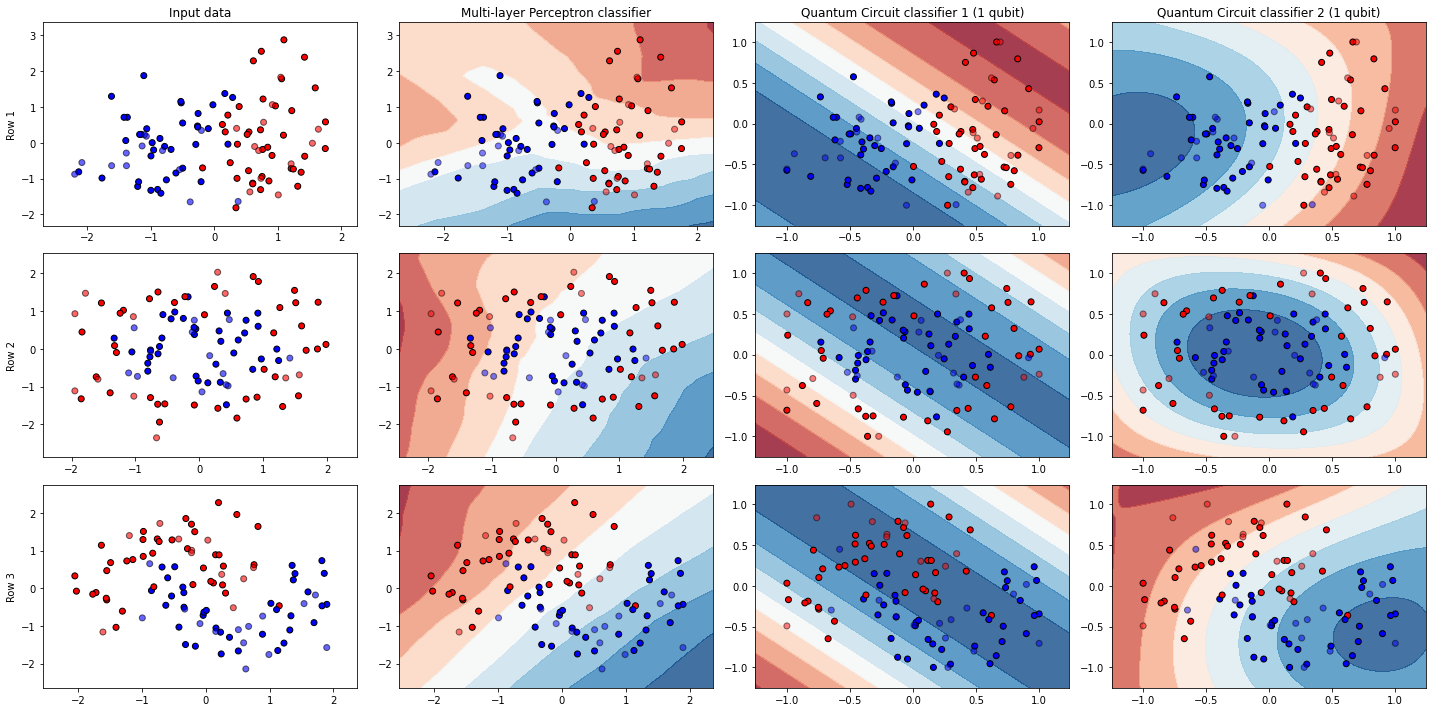

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.7197276 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.6633072 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5791821 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.4618423 | Acc train: 0.5333333 | Acc val: 0.5200000 | Acc all: 0.5200000 
Iter:     5 | Cost: 1.3474438 | Acc train: 0.5200000 | Acc val: 0.5200000 | Acc all: 0.5200000 
Iter:     6 | Cost: 1.2116876 | Acc train: 0.5466667 | Acc val: 0.6000000 | Acc all: 0.5500000 
Iter:     7 | Cost: 1.0707174 | Acc train: 0.5733333 | Acc val: 0.6400000 | Acc all: 0.5800000 
Iter:     8 | Cost: 0.9625645 | Acc train: 0.6266667 | Acc val: 0.6800000 | Acc all: 0.6200000 
Iter:     9 | Cost: 0.8635124 | Acc train: 0.6133333 | Acc val: 0.6800000 | Acc all: 0.6400000 
Iter:    10 | Cost: 0.7906326 | Acc train: 0.6533333 | Acc val: 0.8400000 | Acc all: 0.6600000 
Iter:    11 | Cost: 0.7433206 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.4104454 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.3702996 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.3009530 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.2170477 | Acc train: 0.5600000 | Acc val: 0.5600000 | Acc all: 0.5500000 
Iter:     5 | Cost: 1.1298981 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5600000 
Iter:     6 | Cost: 1.0549844 | Acc train: 0.5866667 | Acc val: 0.6000000 | Acc all: 0.6000000 
Iter:     7 | Cost: 0.9956781 | Acc train: 0.6000000 | Acc val: 0.6800000 | Acc all: 0.6100000 
Iter:     8 | Cost: 0.9380191 | Acc train: 0.6400000 | Acc val: 0.6800000 | Acc all: 0.6500000 
Iter:     9 | Cost: 0.8952625 | Acc train: 0.6800000 | Acc val: 0.6400000 | Acc all: 0.6500000 
Iter:    10 | Cost: 0.8687631 | Acc train: 0.6400000 | Acc val: 0.6800000 | Acc all: 0.6400000 
Iter:    11 | Cost: 0.8557747 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6965376 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.6412942 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5435191 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.4552303 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     5 | Cost: 1.3558952 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     6 | Cost: 1.2725889 | Acc train: 0.5200000 | Acc val: 0.6000000 | Acc all: 0.5200000 
Iter:     7 | Cost: 1.2067672 | Acc train: 0.5600000 | Acc val: 0.5600000 | Acc all: 0.5400000 
Iter:     8 | Cost: 1.1502611 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5700000 
Iter:     9 | Cost: 1.1114519 | Acc train: 0.5333333 | Acc val: 0.5200000 | Acc all: 0.5600000 
Iter:    10 | Cost: 1.0847208 | Acc train: 0.5200000 | Acc val: 0.5200000 | Acc all: 0.5200000 
Iter:    11 | Cost: 1.0662386 | Acc trai

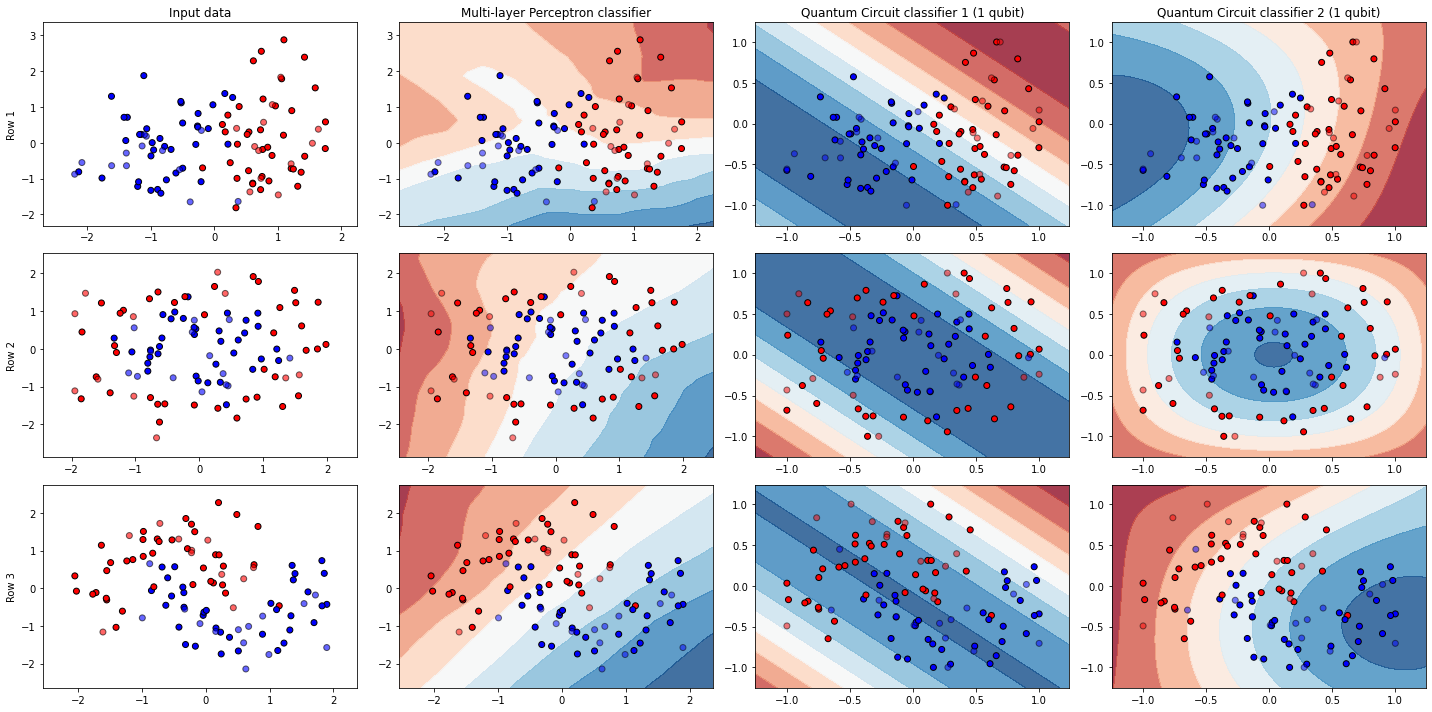

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6809131 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.6217105 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.5207094 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     4 | Cost: 1.4063780 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     5 | Cost: 1.2852596 | Acc train: 0.5733333 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     6 | Cost: 1.1489301 | Acc train: 0.5866667 | Acc val: 0.6400000 | Acc all: 0.5800000 
Iter:     7 | Cost: 1.0310169 | Acc train: 0.6000000 | Acc val: 0.7200000 | Acc all: 0.6100000 
Iter:     8 | Cost: 0.9289734 | Acc train: 0.6400000 | Acc val: 0.7200000 | Acc all: 0.6400000 
Iter:     9 | Cost: 0.8336944 | Acc train: 0.6400000 | Acc val: 0.7600000 | Acc all: 0.6600000 
Iter:    10 | Cost: 0.7490049 | Acc train: 0.6666667 | Acc val: 0.8800000 | Acc all: 0.6800000 
Iter:    11 | Cost: 0.6986139 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.4143364 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.3813768 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.3232985 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.2462676 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     5 | Cost: 1.1614525 | Acc train: 0.5600000 | Acc val: 0.5600000 | Acc all: 0.5600000 
Iter:     6 | Cost: 1.0766156 | Acc train: 0.5600000 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     7 | Cost: 0.9996341 | Acc train: 0.6000000 | Acc val: 0.6800000 | Acc all: 0.6000000 
Iter:     8 | Cost: 0.9353745 | Acc train: 0.6400000 | Acc val: 0.7200000 | Acc all: 0.6300000 
Iter:     9 | Cost: 0.8888435 | Acc train: 0.6666667 | Acc val: 0.7600000 | Acc all: 0.6700000 
Iter:    10 | Cost: 0.8580578 | Acc train: 0.6933333 | Acc val: 0.7200000 | Acc all: 0.7000000 
Iter:    11 | Cost: 0.8405687 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6746983 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.6234815 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5500063 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.4657561 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.3687654 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     6 | Cost: 1.2826311 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     7 | Cost: 1.2040295 | Acc train: 0.5066667 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     8 | Cost: 1.1375658 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5300000 
Iter:     9 | Cost: 1.0933404 | Acc train: 0.5866667 | Acc val: 0.5600000 | Acc all: 0.5700000 
Iter:    10 | Cost: 1.0641586 | Acc train: 0.5733333 | Acc val: 0.5600000 | Acc all: 0.5900000 
Iter:    11 | Cost: 1.0412025 | Acc trai

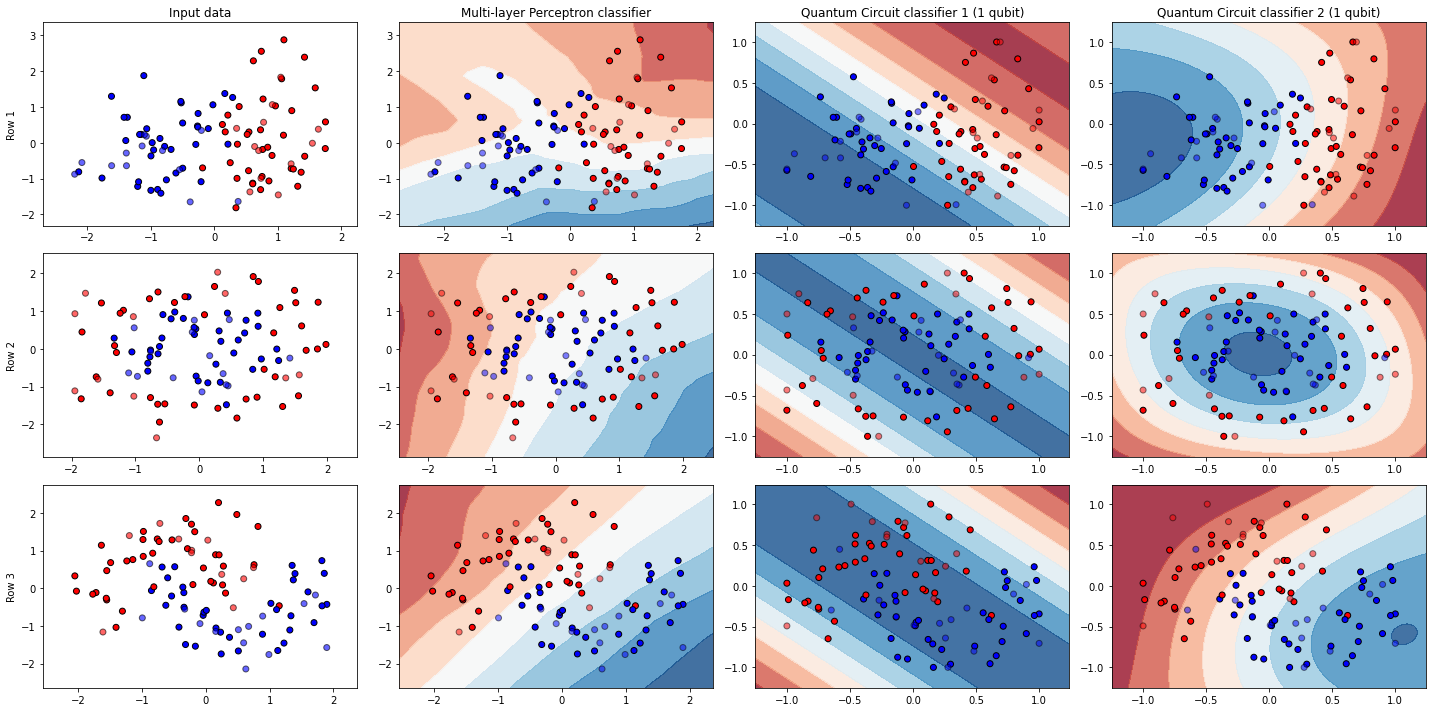

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.7275742 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.6831859 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.6211621 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     4 | Cost: 1.5169265 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5100000 
Iter:     5 | Cost: 1.4082012 | Acc train: 0.5333333 | Acc val: 0.5200000 | Acc all: 0.5300000 
Iter:     6 | Cost: 1.3000986 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5500000 
Iter:     7 | Cost: 1.2002520 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5500000 
Iter:     8 | Cost: 1.0990377 | Acc train: 0.5733333 | Acc val: 0.6000000 | Acc all: 0.5600000 
Iter:     9 | Cost: 1.0198515 | Acc train: 0.6000000 | Acc val: 0.6800000 | Acc all: 0.6100000 
Iter:    10 | Cost: 0.9464969 | Acc train: 0.6133333 | Acc val: 0.6800000 | Acc all: 0.6200000 
Iter:    11 | Cost: 0.8887036 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.3912931 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.3553752 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.2789155 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     4 | Cost: 1.1996734 | Acc train: 0.5600000 | Acc val: 0.5600000 | Acc all: 0.5500000 
Iter:     5 | Cost: 1.1269207 | Acc train: 0.5733333 | Acc val: 0.6000000 | Acc all: 0.5600000 
Iter:     6 | Cost: 1.0600497 | Acc train: 0.6000000 | Acc val: 0.6400000 | Acc all: 0.5900000 
Iter:     7 | Cost: 0.9998276 | Acc train: 0.6133333 | Acc val: 0.6400000 | Acc all: 0.6100000 
Iter:     8 | Cost: 0.9506720 | Acc train: 0.6266667 | Acc val: 0.6000000 | Acc all: 0.6200000 
Iter:     9 | Cost: 0.9170173 | Acc train: 0.5733333 | Acc val: 0.6800000 | Acc all: 0.5700000 
Iter:    10 | Cost: 0.9110918 | Acc train: 0.6000000 | Acc val: 0.6400000 | Acc all: 0.5900000 
Iter:    11 | Cost: 0.9297760 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6739000 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.6261547 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5272601 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.4245604 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.3269449 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     6 | Cost: 1.2532623 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5200000 
Iter:     7 | Cost: 1.1943749 | Acc train: 0.5200000 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     8 | Cost: 1.1384632 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5200000 
Iter:     9 | Cost: 1.0901365 | Acc train: 0.5733333 | Acc val: 0.5600000 | Acc all: 0.5800000 
Iter:    10 | Cost: 1.0541063 | Acc train: 0.5600000 | Acc val: 0.5200000 | Acc all: 0.5700000 
Iter:    11 | Cost: 1.0338590 | Acc trai

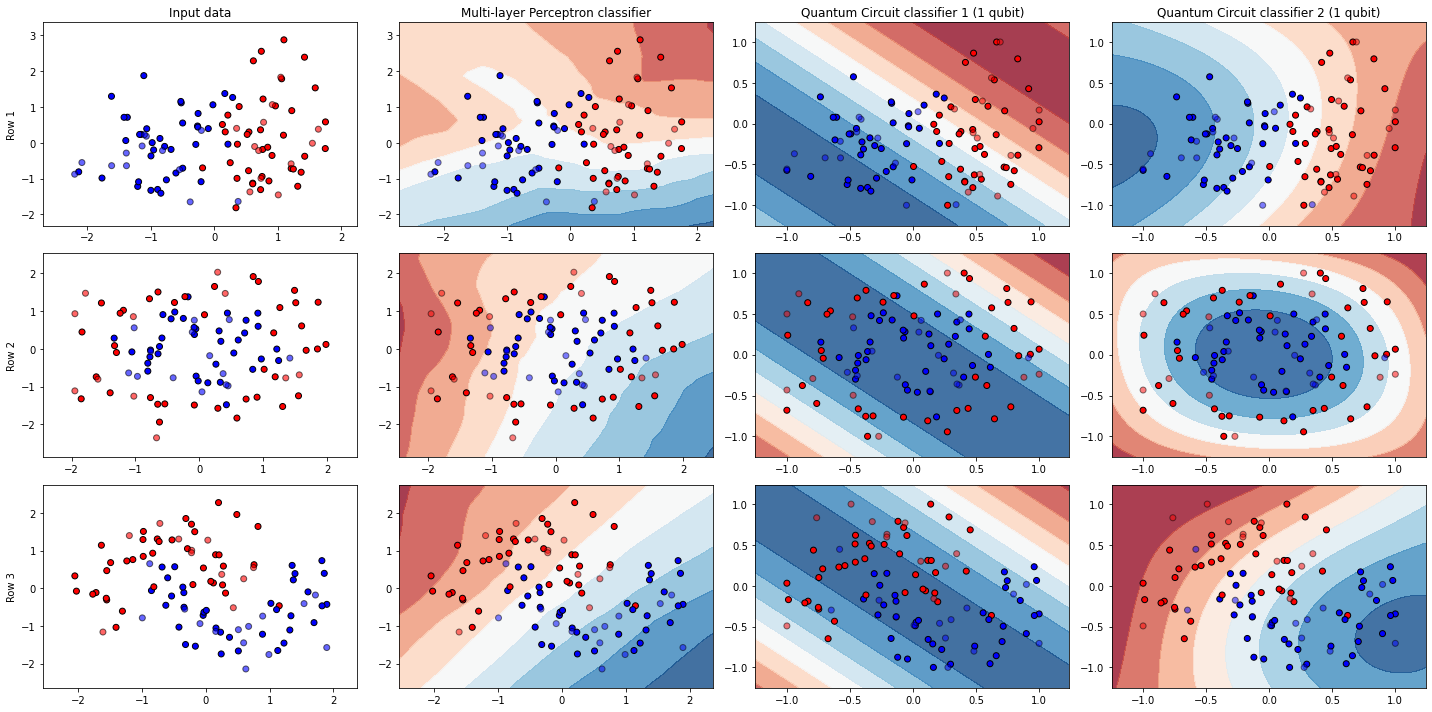

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6993965 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.6301893 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.5156622 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5100000 
Iter:     4 | Cost: 1.3818782 | Acc train: 0.5333333 | Acc val: 0.5200000 | Acc all: 0.5200000 
Iter:     5 | Cost: 1.2449045 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5500000 
Iter:     6 | Cost: 1.1073170 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5600000 
Iter:     7 | Cost: 0.9904058 | Acc train: 0.6000000 | Acc val: 0.6800000 | Acc all: 0.6000000 
Iter:     8 | Cost: 0.8874308 | Acc train: 0.6000000 | Acc val: 0.6800000 | Acc all: 0.6100000 
Iter:     9 | Cost: 0.8217617 | Acc train: 0.6400000 | Acc val: 0.8000000 | Acc all: 0.6400000 
Iter:    10 | Cost: 0.7910127 | Acc train: 0.7066667 | Acc val: 0.7600000 | Acc all: 0.7400000 
Iter:    11 | Cost: 0.7885080 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.4045700 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.3586745 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.2947583 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.2358096 | Acc train: 0.5600000 | Acc val: 0.5600000 | Acc all: 0.5500000 
Iter:     5 | Cost: 1.1683810 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5500000 
Iter:     6 | Cost: 1.1205493 | Acc train: 0.5866667 | Acc val: 0.6000000 | Acc all: 0.5900000 
Iter:     7 | Cost: 1.0730461 | Acc train: 0.6000000 | Acc val: 0.6400000 | Acc all: 0.6000000 
Iter:     8 | Cost: 1.0184297 | Acc train: 0.6133333 | Acc val: 0.6000000 | Acc all: 0.6300000 
Iter:     9 | Cost: 0.9862220 | Acc train: 0.6000000 | Acc val: 0.6000000 | Acc all: 0.6000000 
Iter:    10 | Cost: 0.9737793 | Acc train: 0.5733333 | Acc val: 0.6400000 | Acc all: 0.5600000 
Iter:    11 | Cost: 0.9764339 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6762987 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.6198354 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5349867 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.4536295 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     5 | Cost: 1.3688984 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     6 | Cost: 1.2832879 | Acc train: 0.5066667 | Acc val: 0.6000000 | Acc all: 0.5200000 
Iter:     7 | Cost: 1.2150505 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5300000 
Iter:     8 | Cost: 1.1505532 | Acc train: 0.5600000 | Acc val: 0.5600000 | Acc all: 0.5900000 
Iter:     9 | Cost: 1.1009535 | Acc train: 0.5333333 | Acc val: 0.5200000 | Acc all: 0.5500000 
Iter:    10 | Cost: 1.0746947 | Acc train: 0.5200000 | Acc val: 0.5200000 | Acc all: 0.5200000 
Iter:    11 | Cost: 1.0616460 | Acc trai

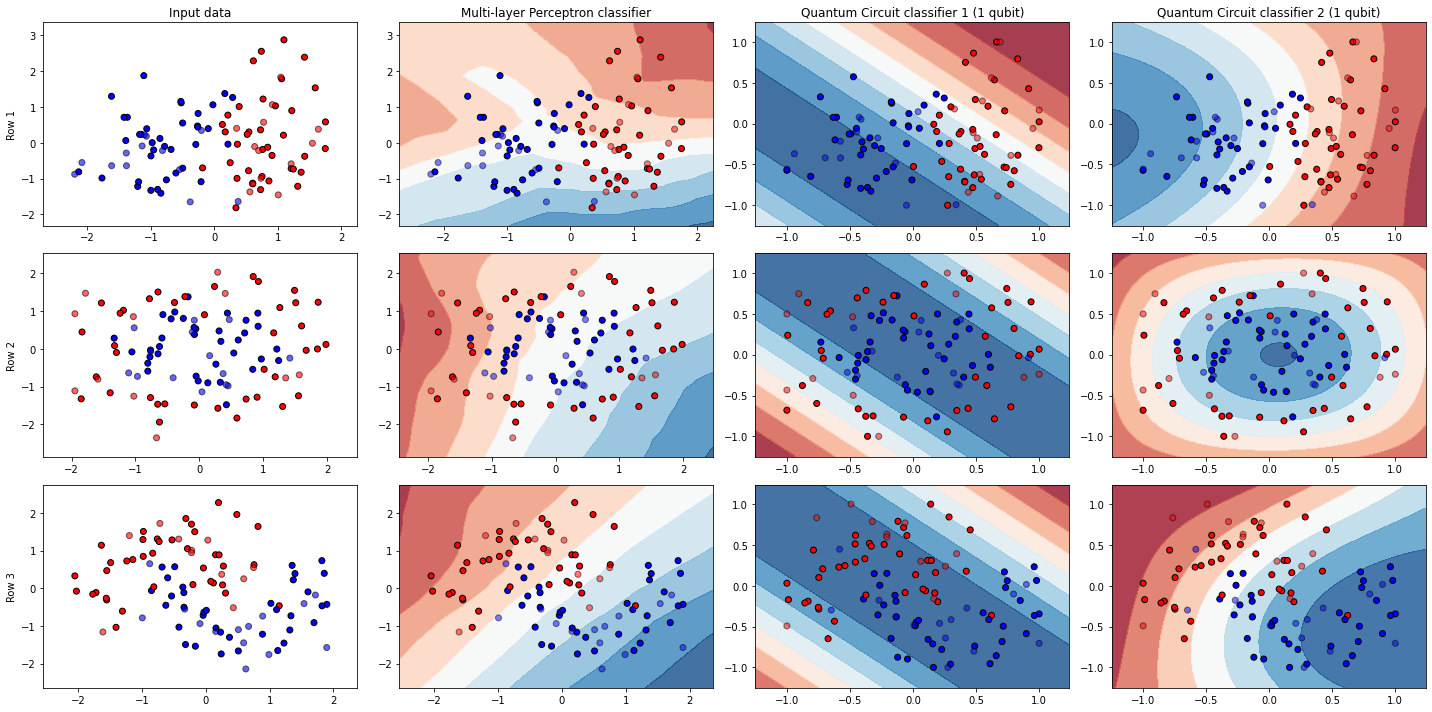

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6961750 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.6363078 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5571261 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.4632592 | Acc train: 0.5333333 | Acc val: 0.5200000 | Acc all: 0.5200000 
Iter:     5 | Cost: 1.3436877 | Acc train: 0.5333333 | Acc val: 0.5200000 | Acc all: 0.5200000 
Iter:     6 | Cost: 1.2471849 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5500000 
Iter:     7 | Cost: 1.1457456 | Acc train: 0.5733333 | Acc val: 0.6000000 | Acc all: 0.5600000 
Iter:     8 | Cost: 1.0458923 | Acc train: 0.5866667 | Acc val: 0.6400000 | Acc all: 0.5800000 
Iter:     9 | Cost: 0.9605087 | Acc train: 0.6266667 | Acc val: 0.6800000 | Acc all: 0.6200000 
Iter:    10 | Cost: 0.8912882 | Acc train: 0.6266667 | Acc val: 0.6800000 | Acc all: 0.6300000 
Iter:    11 | Cost: 0.8275717 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.3962133 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.3469817 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.2986925 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     4 | Cost: 1.2460373 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     5 | Cost: 1.1718362 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5600000 
Iter:     6 | Cost: 1.0956825 | Acc train: 0.5600000 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     7 | Cost: 1.0383282 | Acc train: 0.6000000 | Acc val: 0.6400000 | Acc all: 0.5900000 
Iter:     8 | Cost: 0.9881330 | Acc train: 0.6133333 | Acc val: 0.6400000 | Acc all: 0.6200000 
Iter:     9 | Cost: 0.9410003 | Acc train: 0.6400000 | Acc val: 0.7200000 | Acc all: 0.6200000 
Iter:    10 | Cost: 0.9038926 | Acc train: 0.6533333 | Acc val: 0.7200000 | Acc all: 0.6300000 
Iter:    11 | Cost: 0.8804360 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6684454 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.6040078 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5160180 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.4438363 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     5 | Cost: 1.3632235 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     6 | Cost: 1.2745922 | Acc train: 0.5066667 | Acc val: 0.6000000 | Acc all: 0.5200000 
Iter:     7 | Cost: 1.1873672 | Acc train: 0.5733333 | Acc val: 0.6000000 | Acc all: 0.5300000 
Iter:     8 | Cost: 1.1207703 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5600000 
Iter:     9 | Cost: 1.0753118 | Acc train: 0.5600000 | Acc val: 0.5600000 | Acc all: 0.5800000 
Iter:    10 | Cost: 1.0443787 | Acc train: 0.5466667 | Acc val: 0.5200000 | Acc all: 0.5700000 
Iter:    11 | Cost: 1.0255051 | Acc trai

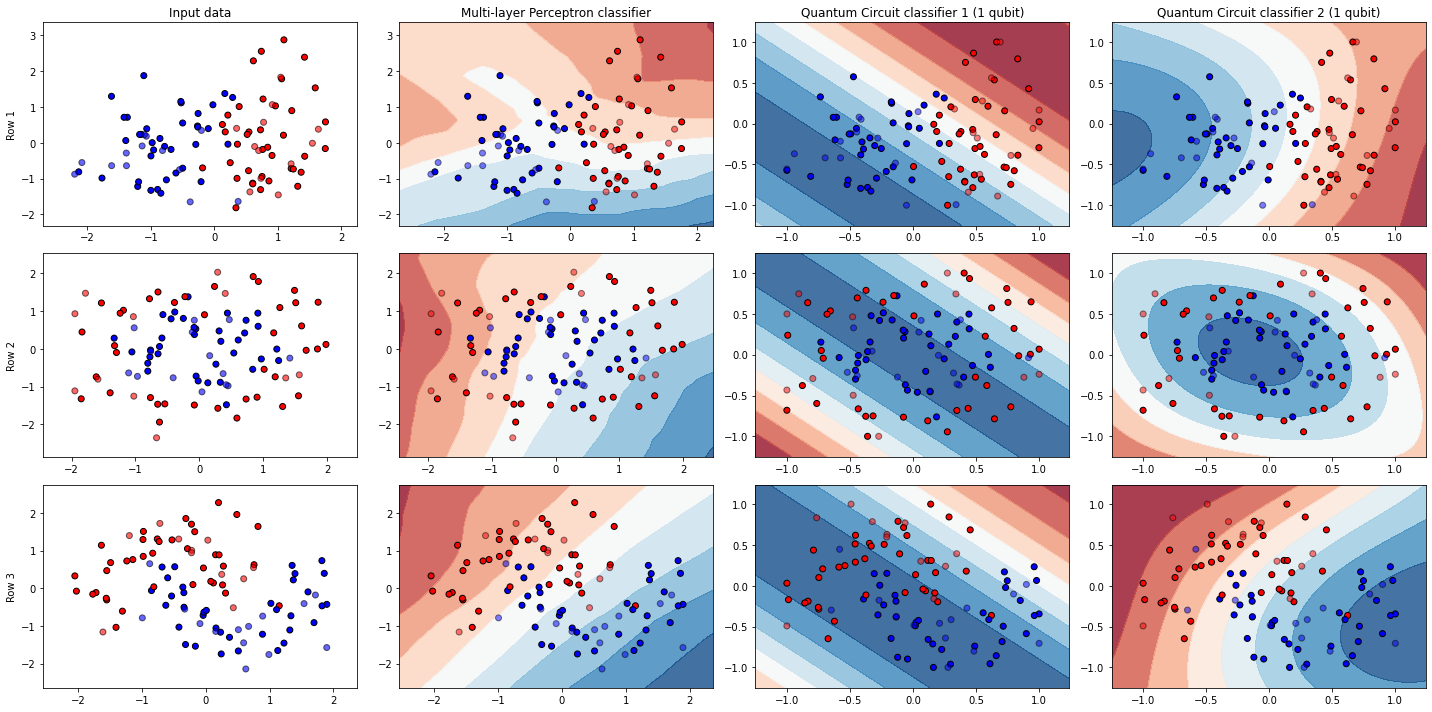

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.7334368 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.6938859 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.6352563 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.5202688 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.4076367 | Acc train: 0.5333333 | Acc val: 0.5200000 | Acc all: 0.5200000 
Iter:     6 | Cost: 1.2868372 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5500000 
Iter:     7 | Cost: 1.1921417 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5500000 
Iter:     8 | Cost: 1.1049095 | Acc train: 0.5733333 | Acc val: 0.6000000 | Acc all: 0.5600000 
Iter:     9 | Cost: 1.0230984 | Acc train: 0.6000000 | Acc val: 0.6800000 | Acc all: 0.6000000 
Iter:    10 | Cost: 0.9362801 | Acc train: 0.6266667 | Acc val: 0.6800000 | Acc all: 0.6300000 
Iter:    11 | Cost: 0.8608343 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.4270637 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.3858315 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.3266678 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.2643175 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     5 | Cost: 1.1856798 | Acc train: 0.5333333 | Acc val: 0.6000000 | Acc all: 0.5400000 
Iter:     6 | Cost: 1.1185662 | Acc train: 0.5866667 | Acc val: 0.6000000 | Acc all: 0.5700000 
Iter:     7 | Cost: 1.0509902 | Acc train: 0.6000000 | Acc val: 0.6400000 | Acc all: 0.5800000 
Iter:     8 | Cost: 0.9787658 | Acc train: 0.6000000 | Acc val: 0.6800000 | Acc all: 0.5900000 
Iter:     9 | Cost: 0.9189938 | Acc train: 0.6533333 | Acc val: 0.7200000 | Acc all: 0.6500000 
Iter:    10 | Cost: 0.8729581 | Acc train: 0.6666667 | Acc val: 0.8000000 | Acc all: 0.6900000 
Iter:    11 | Cost: 0.8435967 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6858388 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.6310785 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5871464 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.5207383 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.4425245 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     6 | Cost: 1.3704328 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.4900000 
Iter:     7 | Cost: 1.2991856 | Acc train: 0.5066667 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     8 | Cost: 1.2200302 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     9 | Cost: 1.1567645 | Acc train: 0.4933333 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:    10 | Cost: 1.1131327 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.4900000 
Iter:    11 | Cost: 1.0670912 | Acc trai

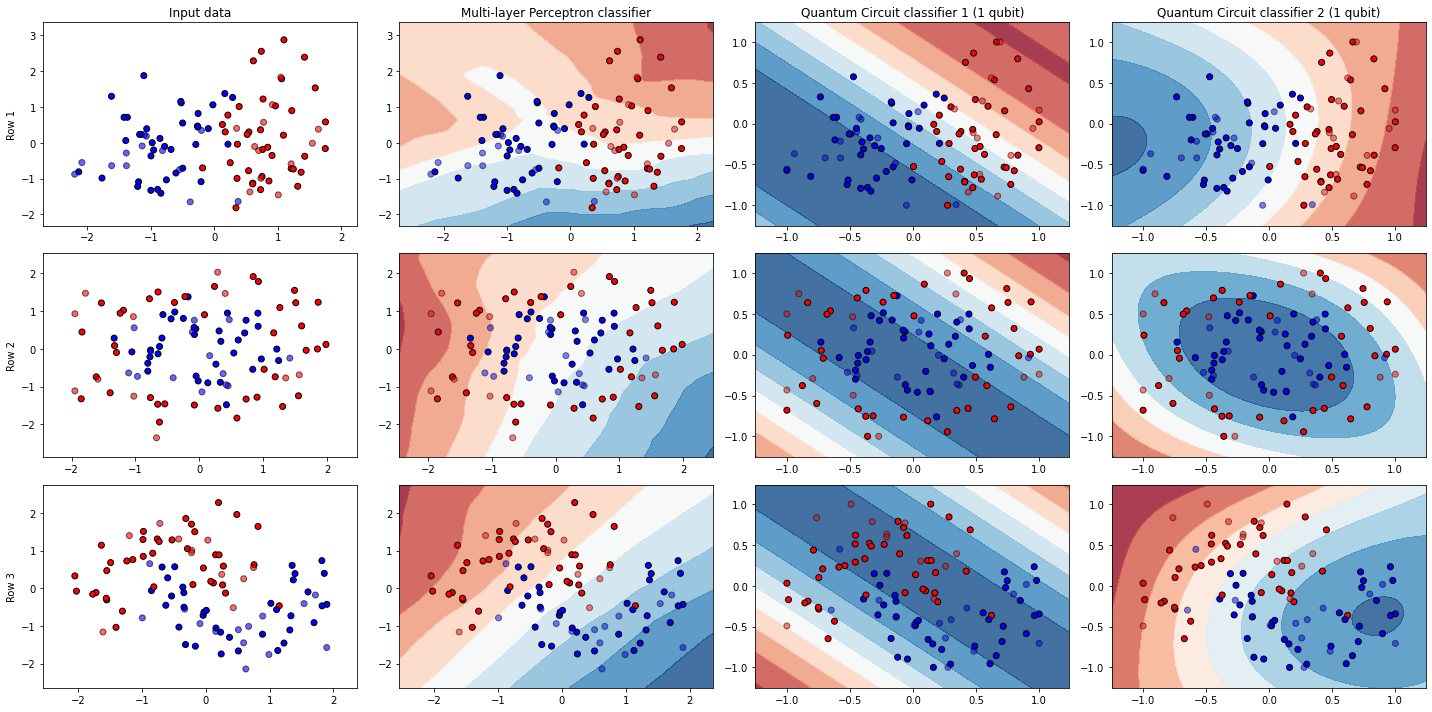

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.7188783 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.6692513 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.6182525 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     4 | Cost: 1.5464882 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     5 | Cost: 1.4409651 | Acc train: 0.5466667 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     6 | Cost: 1.3038762 | Acc train: 0.5733333 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     7 | Cost: 1.1389600 | Acc train: 0.5866667 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     8 | Cost: 0.9908577 | Acc train: 0.6266667 | Acc val: 0.7200000 | Acc all: 0.6300000 
Iter:     9 | Cost: 0.8679482 | Acc train: 0.6266667 | Acc val: 0.7200000 | Acc all: 0.6300000 
Iter:    10 | Cost: 0.7876328 | Acc train: 0.6666667 | Acc val: 0.7600000 | Acc all: 0.6800000 
Iter:    11 | Cost: 0.7250931 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.4027120 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.3767636 | Acc train: 0.5066667 | Acc val: 0.5600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.3298004 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.2860502 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:     5 | Cost: 1.2278643 | Acc train: 0.5200000 | Acc val: 0.6000000 | Acc all: 0.5400000 
Iter:     6 | Cost: 1.1678188 | Acc train: 0.5466667 | Acc val: 0.6000000 | Acc all: 0.5500000 
Iter:     7 | Cost: 1.1113513 | Acc train: 0.5600000 | Acc val: 0.6400000 | Acc all: 0.5500000 
Iter:     8 | Cost: 1.0570341 | Acc train: 0.5866667 | Acc val: 0.6400000 | Acc all: 0.5700000 
Iter:     9 | Cost: 0.9980702 | Acc train: 0.6133333 | Acc val: 0.6400000 | Acc all: 0.6100000 
Iter:    10 | Cost: 0.9455472 | Acc train: 0.6400000 | Acc val: 0.7200000 | Acc all: 0.6200000 
Iter:    11 | Cost: 0.9051139 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6769842 | Acc train: 0.4800000 | Acc val: 0.5600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.6153318 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.5558384 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.4804173 | Acc train: 0.4800000 | Acc val: 0.6000000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.3902673 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     6 | Cost: 1.2811954 | Acc train: 0.4933333 | Acc val: 0.6000000 | Acc all: 0.5200000 
Iter:     7 | Cost: 1.1959165 | Acc train: 0.5333333 | Acc val: 0.6000000 | Acc all: 0.5100000 
Iter:     8 | Cost: 1.1403824 | Acc train: 0.5600000 | Acc val: 0.6000000 | Acc all: 0.5300000 
Iter:     9 | Cost: 1.0938979 | Acc train: 0.5866667 | Acc val: 0.5600000 | Acc all: 0.6000000 
Iter:    10 | Cost: 1.0620892 | Acc train: 0.5600000 | Acc val: 0.5600000 | Acc all: 0.5700000 
Iter:    11 | Cost: 1.0434258 | Acc trai

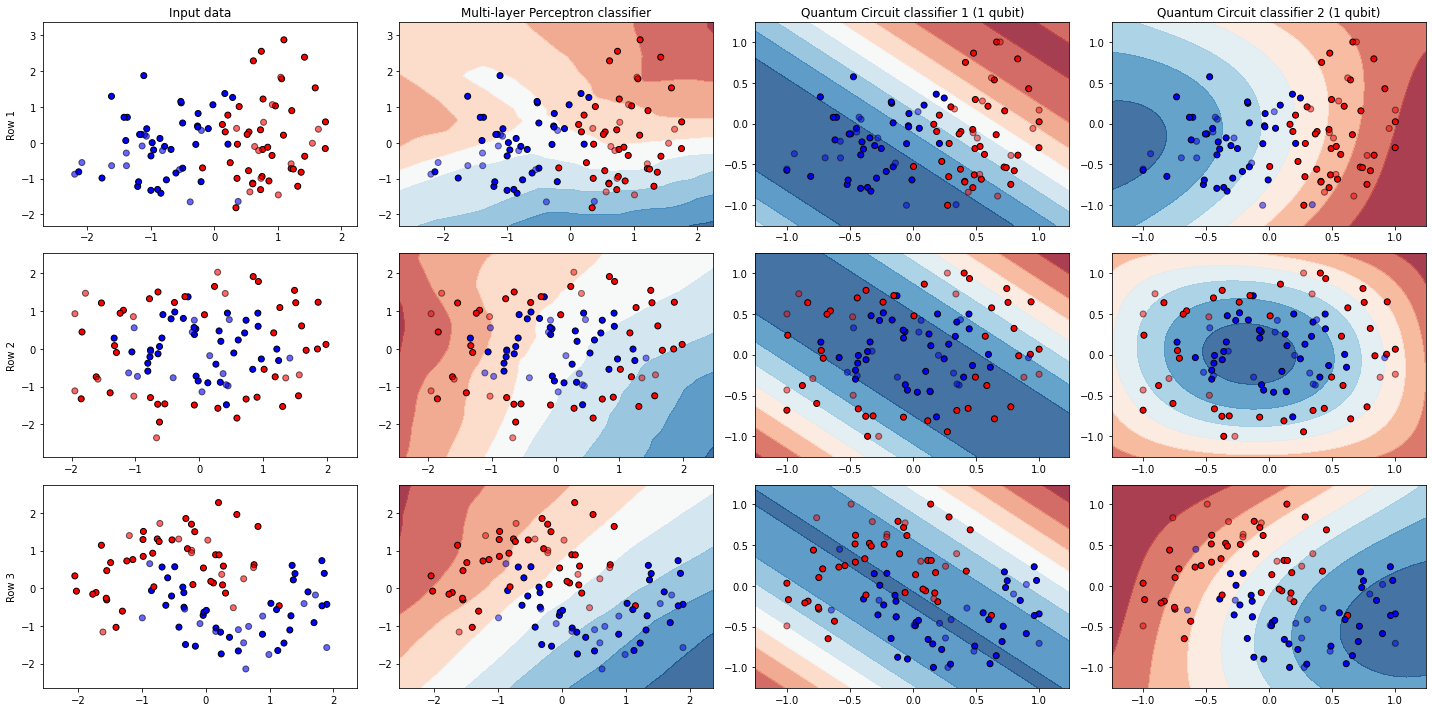

scores: [[[0.56 0.68 0.76]
  [0.56 0.68 0.76]
  [0.56 0.68 0.76]
  [0.56 0.68 0.76]
  [0.56 0.68 0.76]
  [0.56 0.68 0.76]
  [0.56 0.68 0.76]
  [0.56 0.68 0.76]
  [0.56 0.68 0.76]
  [0.56 0.68 0.76]
  [0.56 0.68 0.76]
  [0.56 0.68 0.76]
  [0.56 0.68 0.76]]

 [[0.92 0.76 0.36]
  [0.84 0.8  0.6 ]
  [0.84 0.72 0.72]
  [0.84 0.76 0.8 ]
  [0.84 0.72 0.52]
  [0.92 0.68 0.36]
  [0.84 0.68 0.6 ]
  [0.88 0.72 0.56]
  [0.88 0.8  0.72]
  [0.84 0.72 0.56]
  [0.84 0.72 0.76]
  [0.84 0.68 0.32]
  [0.84 0.8  0.56]]

 [[0.92 0.64 0.76]
  [0.92 0.72 0.76]
  [0.92 0.8  0.76]
  [0.92 0.76 0.72]
  [0.92 0.64 0.76]
  [0.92 0.8  0.8 ]
  [0.92 0.88 0.72]
  [0.92 0.84 0.76]
  [0.92 0.8  0.8 ]
  [0.92 0.48 0.72]
  [0.92 0.64 0.8 ]
  [0.92 0.88 0.76]
  [0.92 0.84 0.72]]]


In [5]:
halfPi = pi/2
# h = 0.02  # step size in the mesh
h = 0.03  # step size in the mesh
n_samples = 100

names = [
    "Multi-layer Perceptron classifier",
    # "Linear SVM",
    # "Quantum classifier circuit 1",
    "Quantum Circuit classifier 1 (1 qubit)",
    "Quantum Circuit classifier 2 (1 qubit)",
]

classifiers = [
  MLPClassifier(random_state=1, max_iter=max_iterations, 
                    solver="sgd", nesterovs_momentum=True),
  # SVC(kernel="linear", C=0.025),
  # [vc_quantum, vc_classifier_1, init_weights_1, circuit_1],
  [vc_quantum, vc_classifier_2, init_weights_2, circuit_2],
  [vc_quantum, vc_classifier_3, init_weights_3, circuit_3],
]

X, y = make_classification(
    n_samples=n_samples,
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
)
rng = numpy.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [
    linearly_separable,
    make_circles(n_samples=n_samples, noise=0.2, factor=0.5, random_state=1),
    make_moons(n_samples=n_samples, noise=0.3, random_state=0),
]

# initalize scores array
scores = np.zeros(shape=(len(classifiers),loop_count,len(datasets)))

#############
# Main Loop #
#############
for l_count in range(loop_count):
  figure = plt.figure(figsize=(20, 10))
  # Figure: set white background
  figure.patch.set_facecolor('xkcd:white')

  i = 1
  # iterate over datasets
  for ds_cnt, ds in enumerate(datasets):
      # preprocess dataset, split into training and test part
      X, y = ds
      
      X = StandardScaler().fit_transform(X)
      X_train, X_test, y_train, y_test = train_test_split(
          X, y, test_size=0.25, random_state=1
      )
      x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
      y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
      xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
      
      # scale data for quantum data
      y_train_quantum = np.where(y_train==0, y_train-1, y_train)
      y_test_quantum = np.where(y_test==0, y_test-1, y_test)
      y_quantum = np.where(y==0, y-1, y)
      
      scale_value=1
      X_scaled = MinMaxScaler(feature_range=(-scale_value,scale_value), copy=True).fit_transform(X)
      X_train_scaled = MinMaxScaler(feature_range=(-scale_value,scale_value), copy=True).fit_transform(X_train)
      X_test_scaled = MinMaxScaler(feature_range=(-scale_value,scale_value), copy=True).fit_transform(X_test)

      x_min_scaled, x_max_scaled = X_scaled[:, 0].min() - 0.25, X_scaled[:, 0].max() + 0.25
      y_min_scaled, y_max_scaled = X_scaled[:, 1].min() - 0.25, X_scaled[:, 1].max() + 0.25
      xx_scaled, yy_scaled = np.meshgrid(np.arange(x_min_scaled, x_max_scaled, h), np.arange(y_min_scaled, y_max_scaled, h))

      # just plot the dataset first
      cm = plt.cm.RdBu
      cm_bright = ListedColormap(["#FF0000", "#0000FF"])
      ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
      if ds_cnt == 0:
          ax.set_title("Input data")
      ax.set(ylabel='Row ' + str(ds_cnt+1))
      # Plot the training points
      ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
      # Plot the testing points
      ax.scatter(
          X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
      )
      ax.set_xlim(xx.min(), xx.max())
      ax.set_ylim(yy.min(), yy.max())
      #ax.set_xticks(())
      #ax.set_yticks(())
      i += 1

      classifier_count=0
      # iterate over classifiers
      for name, clf in zip(names, classifiers):
          ax = plt.subplot(len(datasets), len(classifiers) + 1, i)

          if 'Quantum' in name:
            # Quantum circuit #
            vars, score = clf[0](clf[1], clf[2], X_train_scaled, X_test_scaled, X_scaled, y_train_quantum, y_test_quantum, y_quantum)
            Z = np.array(
              [clf[1](vars, f) for f in np.c_[xx_scaled.ravel(), yy_scaled.ravel()]]
            )

            # Put the result into a color plot
            Z = Z.reshape(xx_scaled.shape)
            ax.contourf(xx_scaled, yy_scaled, Z, cmap=cm, alpha=0.8)
            
            # Plot the training points
            ax.scatter(
                X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train_quantum, cmap=cm_bright, edgecolors="k"
            )
            # Plot the testing points
            ax.scatter(
                X_test_scaled[:, 0],
                X_test_scaled[:, 1],
                c=y_test_quantum,
                cmap=cm_bright,
                edgecolors="k",
                alpha=0.5,
            )

            ax.set_xlim(xx_scaled.min(), xx_scaled.max())
            ax.set_ylim(yy_scaled.min(), yy_scaled.max())
            
            # print scores
            # ax.text(
            #   xx_scaled.max() - 0.15,
            #   yy_scaled.min() + 0.15,
            #   ("Score: %.2f" % score).lstrip("0"),
            #   size=15,
            #   horizontalalignment="right",
            # )
            
          else:
            # Classical circuits #
            clf.fit(X_train, y_train)
            score = clf.score(X_test, y_test)

            # Plot the decision boundary. For that, we will assign a color to each
            # point in the mesh [x_min, x_max]x[y_min, y_max].
            if hasattr(clf, "decision_function"):
                Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
            else:
                Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

            # Put the result into a color plot
            Z = Z.reshape(xx.shape)
            ax.contourf(xx, yy, Z, cmap=cm, alpha=0.8)
                
            # Plot the training points
            ax.scatter(
                X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
            )
            # Plot the testing points
            ax.scatter(
                X_test[:, 0],
                X_test[:, 1],
                c=y_test,
                cmap=cm_bright,
                edgecolors="k",
                alpha=0.5,
            )

            ax.set_xlim(xx.min(), xx.max())
            ax.set_ylim(yy.min(), yy.max())

            # print scores
            # ax.text(
            #   xx.max() - 0.3,
            #   yy.min() + 0.3,
            #   ("Score: %.2f" % score).lstrip("0"),
            #   size=15,
            #   horizontalalignment="right",
            # )
          
          scores[classifier_count][l_count][ds_cnt] = score
          # ax.set_xticks(())
          # ax.set_yticks(())
          if ds_cnt == 0:
              ax.set_title(name)
          i += 1
          classifier_count += 1

  plt.tight_layout()
  plt.show()

print("scores:", scores)

In [6]:
for name, clf in zip(names, classifiers):
    if 'Quantum' in name:
      print(name)
      print(clf[3].draw())


Quantum Circuit classifier 1 (1 qubit)
 0: ──RY(1.24)──Rot(-0.00572, 0.0994, -0.00254)──RY(1.24)──Rot(-0.00404, 0.0678, 0.00405)──┤ ⟨Z⟩ 

Quantum Circuit classifier 2 (1 qubit)
 0: ──RY(1.24)──Rot(-0.116, -0.468, 0.29)──RX(1.24)──Rot(-0.593, -0.808, -0.00838)──┤ ⟨Z⟩ 



C:\Users\zero\anaconda3\lib\site-packages\pennylane\qnode.py:838: UserWarning: The QNode.draw method has been deprecated. Please use the qml.draw(qnode)(*args) function instead.
  warnings.warn(
